In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from rl_envs_forge.envs.grid_world.grid_world import GridWorld
from rl_envs_forge.envs.grid_world.mdp.mdp import GridWorldMDP
from rl_envs_forge.envs.grid_world.grid_world import Action

from src.replay_buffer import ReplayBuffer
from src.policy_iteration import policy_evaluation_v, find_optimal_policy_q
from src.visualize import draw_simple_gridworld

In [4]:
# Generate states splits

rows, cols = 10, 10  
terminal_states = {(4, 4)}

# Generate all possible states and exclude terminal states
all_states = [(row, col) for row in range(rows) for col in range(cols)]
available_states = [state for state in all_states if state not in terminal_states]

def train_validation_split(states, train_ratio=0.8):
    random.shuffle(states)
    split_idx = int(len(states) * train_ratio)
    train_states = states[:split_idx]
    test_states = states[split_idx:]
    return train_states, test_states

# Split the available states into training and validation sets
train_states, test_states = train_validation_split(available_states, train_ratio=0.95)

print("Number of Training States:", len(train_states))
print("Number of Validation States:", len(test_states))

Number of Training States: 94
Number of Validation States: 5


In [5]:
def make_env(rows, cols, start_state, random_move_frequency, terminal_states, seed):
    return GridWorld(
        rows=rows,
        cols=cols,
        start_state = start_state,
        walls=None,
        random_move_frequency=random_move_frequency,
        terminal_states={key: 1.0 for key in terminal_states},
        seed = seed,
        rewards = {
            "valid_move": 0,
            "wall_collision": 0,
            "out_of_bounds": 0, 
            "default": 0.0,
        }
    )

def generate_samples(rows, cols, start_state, terminal_states, random_move_frequency, num_steps, seed=0):
    dataset = []
    env = make_env(rows, cols, start_state, 1.0, terminal_states, seed)
    state = env.reset()
    done = False
    for _ in range(num_steps):
        action = np.random.choice([0, 1, 2, 3])  # UP, RIGHT, DOWN, LEFT
        next_state, reward, done, _, _ = env.step(action)
        
        sample = [state, action, reward, next_state, done]
        dataset.append(sample)
        
        if done:
            state = env.reset()
            done = False
            
        state = next_state
        
    return dataset
    
seed = 0
random_move_frequency = 1.0
num_steps = 10_000

train_dataset = []
for start_state in train_states:
    start_state_dataset = generate_samples(rows, cols, start_state, terminal_states, random_move_frequency, num_steps, seed)
    train_dataset.extend(start_state_dataset)

test_dataset = []
for start_state in test_states:
    start_state_dataset = generate_samples(rows, cols, start_state, terminal_states, random_move_frequency, num_steps, seed)
    test_dataset.extend(start_state_dataset)

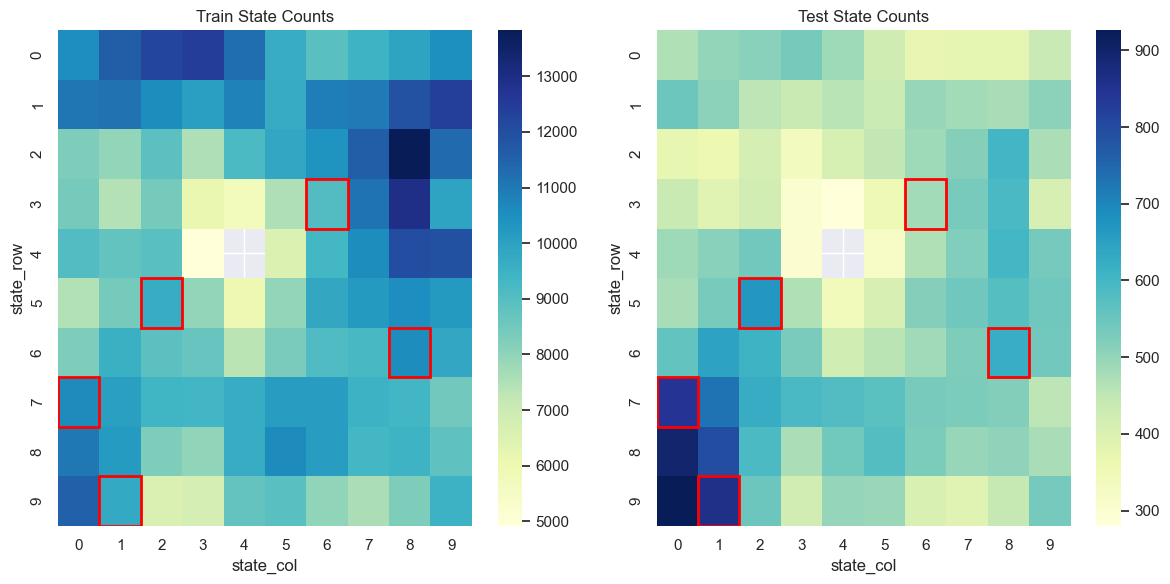

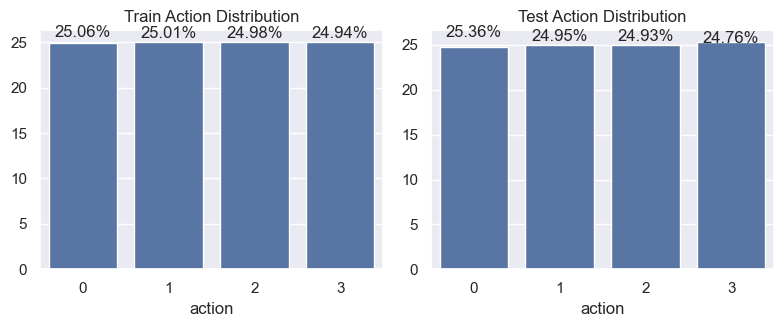

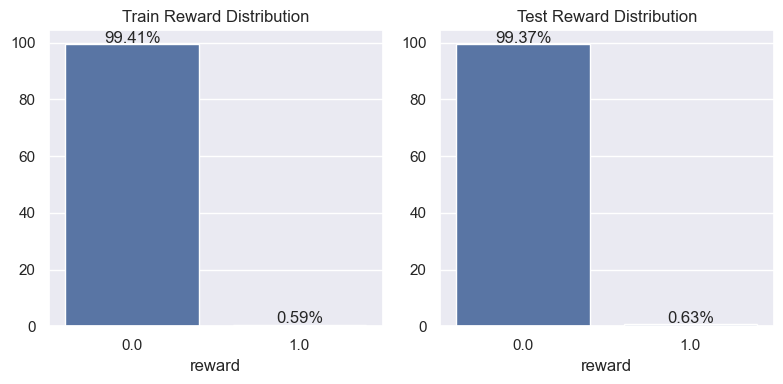

Training Percentage of 'done': 0.59%
Test Percentage of 'done': 0.63%


In [8]:
# Convert dataset to DataFrame
columns = ['state', 'action', 'reward', 'next_state', 'done']

df = pd.DataFrame(train_dataset, columns=columns)
df[['state_row', 'state_col']] = pd.DataFrame(df['state'].tolist(), index=df.index)
df[['next_state_row', 'next_state_col']] = pd.DataFrame(df['next_state'].tolist(), index=df.index)

test_df = pd.DataFrame(test_dataset, columns=columns)
test_df[['state_row', 'state_col']] = pd.DataFrame(test_df['state'].tolist(), index=test_df.index)
test_df[['next_state_row', 'next_state_col']] = pd.DataFrame(test_df['next_state'].tolist(), index=test_df.index)

###### Figure for state counts heatmaps
train_state_counts = df.groupby(['state_row', 'state_col']).size().reset_index(name='counts')
train_state_heatmap = train_state_counts.pivot(index='state_row', columns='state_col', values='counts')

# Test Dataset State Counts
test_state_counts = test_df.groupby(['state_row', 'state_col']).size().reset_index(name='counts')
test_state_heatmap = test_state_counts.pivot(index='state_row', columns='state_col', values='counts')

plt.figure(figsize=(12, 6))

# Plot Train State Counts Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(train_state_heatmap, annot=False, cmap="YlGnBu")
plt.title('Train State Counts')

for state in test_states:
    # Convert state tuple to row, col indices considering the heatmap's orientation
    row, col = state
    plt.gca().add_patch(plt.Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))


plt.subplot(1, 2, 2)
sns.heatmap(test_state_heatmap, annot=False, cmap="YlGnBu")
plt.title('Test State Counts')

for state in test_states:
    # Convert state tuple to row, col indices considering the heatmap's orientation
    row, col = state
    plt.gca().add_patch(plt.Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))

plt.tight_layout()
plt.show()

##########
# Training Action Distribution
plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)

train_action_counts = df['action'].value_counts(normalize=True) * 100
sns.barplot(x=train_action_counts.index, y=train_action_counts.values)
plt.title('Train Action Distribution')
for i, value in enumerate(train_action_counts.values):
    plt.text(i, value + 0.5, f'{value:.2f}%', ha='center')

# Test Action Distribution
plt.subplot(2, 2, 2)
test_action_counts = test_df['action'].value_counts(normalize=True) * 100
sns.barplot(x=test_action_counts.index, y=test_action_counts.values)
plt.title('Test Action Distribution')
for i, value in enumerate(test_action_counts.values):
    plt.text(i, value + 0.5, f'{value:.2f}%', ha='center')

plt.tight_layout()
plt.show()

##### Figure for actions and rewards
plt.figure(figsize=(8, 4))

# Training Reward Distribution
plt.subplot(1, 2, 1)
train_reward_counts = df['reward'].value_counts(normalize=True, sort=False).sort_index() * 100
sns.barplot(x=train_reward_counts.index, y=train_reward_counts.values)
plt.title('Train Reward Distribution')
for i, value in enumerate(train_reward_counts.values):
    plt.text(i, value + 0.5, f'{value:.2f}%', ha='center')

# Test Reward Distribution
plt.subplot(1, 2, 2)
test_reward_counts = test_df['reward'].value_counts(normalize=True, sort=False).sort_index() * 100
sns.barplot(x=test_reward_counts.index, y=test_reward_counts.values)
plt.title('Test Reward Distribution')
for i, value in enumerate(test_reward_counts.values):
    plt.text(i, value + 0.5, f'{value:.2f}%', ha='center')

plt.tight_layout()
plt.show()

##### Percentages of done
train_done_percentage = df['done'].mean() * 100
test_done_percentage = test_df['done'].mean() * 100
print(f"Training Percentage of 'done': {train_done_percentage:.2f}%")
print(f"Test Percentage of 'done': {test_done_percentage:.2f}%")

In [ ]:
# 5 seeds
# Idea 1: generate all the unique transitions in the MDP, use some for training, some for validation 20% 
OR, variation 2: select initially some transitions we want in validation, and MOVE them from the training to the validation one
# select probability generated by us with softmax(logits, 0.1 or 100) logits: random uniform\
# at each experiment modify tau, decrease it
# Compute the times we select each trainsition by making numpy choice with probabilities
# take  4000 samples like this: in validation we should have all the possible transitions
# TD learning on training data -> Q, minibatch, for each transition, Stop TD learning when we reach Q* within epsilon
# Calculate Q* and Q train, Q test, and compute regret between them, setup terminal state in corner
# TD learning on validation data -> Q
